In [1]:
# Example parameters
model_dir = '../../tests/data/output/test1'

gpu = 0
memfrac_gpu = 0.45
in_memory = False
num_workers = 8

In [2]:
import bpnet
import pandas as pd
import numpy as np
import os
from pathlib import Path
from bpnet.dataspecs import DataSpec, TaskSpec
from bpnet.utils import create_tf_session
from bpnet.seqmodel import SeqModel
from bpnet.plot.evaluate import plot_loss, regression_eval

Using TensorFlow backend.


In [3]:
model_dir = Path(model_dir)

In [5]:
history_file = model_dir / "history.csv"

In [6]:
create_tf_session(gpu)

In [16]:
model = SeqModel.from_mdir(model_dir)

## Learning curves

In [8]:
ds = DataSpec.load(model_dir / 'dataspec.yml')
tasks = list(ds.task_specs)

In [9]:
# Best metrics
dfh = pd.read_csv(history_file)
dict(dfh.iloc[dfh.val_loss.idxmin()])

{'epoch': 0.0,
 'Task1/counts_loss': 36.15608978271485,
 'Task1/profile_loss': 2632.7242431640625,
 'loss': 2994.28515625,
 'val_Task1/counts_loss': 38.20741653442383,
 'val_Task1/profile_loss': 9611.14697265625,
 'val_loss': 9993.22119140625}

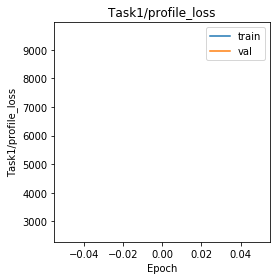

In [10]:
plot_loss(dfh, [f"{task}/{p}_loss"
                for task in tasks
                for p in ['profile']
               ], figsize=(len(tasks)*4, 4))

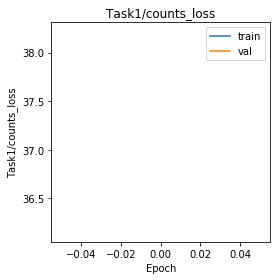

In [11]:
plot_loss(dfh, [f"{task}/{p}_loss"
                for task in tasks
                for p in ['counts']
               ], figsize=(len(tasks)*4, 4))

## Evaluation

Print the metrics:

In [12]:
!cat {model_dir}/evaluation.valid.json

{
  "valid-peaks": {
    "Task1/profile/binsize=1/auprc": NaN,
    "Task1/profile/binsize=1/random_auprc": NaN,
    "Task1/profile/binsize=1/n_positives": 0,
    "Task1/profile/binsize=1/frac_ambigous": 0.0,
    "Task1/profile/binsize=1/imbalance": 0.0,
    "Task1/profile/binsize=10/auprc": NaN,
    "Task1/profile/binsize=10/random_auprc": NaN,
    "Task1/profile/binsize=10/n_positives": 0,
    "Task1/profile/binsize=10/frac_ambigous": 0.0,
    "Task1/profile/binsize=10/imbalance": 0.0,
    "Task1/counts/mse": 38.897003173828125,
    "Task1/counts/var_explained": -Infinity,
    "Task1/counts/pearsonr": NaN,
    "Task1/counts/spearmanr": NaN,
    "Task1/counts/mad": 6.236296653747559,
    "avg/profile/binsize=1/auprc": NaN,
    "avg/profile/binsize=1/random_auprc": NaN,
    "avg/profile/binsize=1/n_positives": 0.0,
    "avg/profile/binsize=1/frac_ambigous": 0.0,
    "avg/profile/binsize=1/imbalance": 0.0,
    "avg/profile/binsize=10/auprc": NaN,
    "avg/profile/binsize=10/random_auprc"

In [13]:
from bpnet.utils import read_json
gin_config = read_json(model_dir / 'config.gin.json')

In [14]:
from bpnet.datasets import StrandedProfile

In [15]:
# TODO - add intervals?
dl_valid = StrandedProfile(ds, 
                           incl_chromosomes=gin_config['bpnet_data.valid_chr'], 
                           peak_width=gin_config['bpnet_data.peak_width'],
                           seq_width=gin_config['bpnet_data.seq_width'],
                           shuffle=False)

In [16]:
valid = dl_valid.load_all(num_workers=num_workers)

100%|██████████| 1/1 [00:00<00:00, 60.78it/s]


In [19]:
y_pred = model.predict(valid['inputs']['seq'])

In [20]:
y_true = valid['targets']

In [21]:
import matplotlib.pyplot as plt

/data/ouga/home/ag_gagneur/avsec/.conda/envs/bpnet/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/data/ouga/home/ag_gagneur/avsec/.conda/envs/bpnet/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/data/ouga/home/ag_gagneur/avsec/.conda/envs/bpnet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/data/ouga/home/ag_gagneur/avsec/.conda/envs/bpnet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/data/ouga/home/ag_gagneur/avsec/.conda/envs/bpnet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value en

<Figure size 432x288 with 0 Axes>

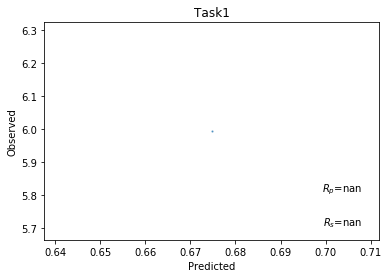

In [22]:
for task in tasks:
    plt.figure()
    yt = y_true[f'{task}/counts'].mean(-1)
    yp = y_pred[f'{task}/counts'].mean(-1)
    regression_eval(yt, 
                    yp, alpha=0.1, task=task)

## Profile plots

In [23]:
peak_width = gin_config['bpnet_data.peak_width']

In [24]:
np.random.seed(42)

N_RANDOM = 2
N_TOP_TOTAL_COUNT = 2
N_TOP_PER_BASE_COUNT = 2

def random_samples(arr, n=10, keep=None):
    """
    Randomly sample the values
      arr: numpy array
      n = number of samples to draw
    """
    if keep is None:
        keep = np.arange(len(arr))
    return list(pd.Series(np.arange(len(arr)))[keep].sample(n).index)


def top_summary_count(arr, end=10, start=0, keep=None, summary_fn=np.max):
    """
    Return indices where arr has the highest max(pos) + max(neg)

    Args:
      arr: can be an array or a list of arrays
      start: Where to start returning the values
      end: where to stop
    """
    if keep is None:
        keep = np.arange(len(arr))
    assert end > start
    # Top maxcount indicies
    return pd.Series(summary_fn(arr, axis=1).sum(1))[keep].sort_values(ascending=False).index[start:end]

# Check how much of the total counts is allocated at a single position
yt = sum([y_true[f'{task}/profile']
          for task in tasks])

(yt / yt.sum(axis=1, keepdims=True)).max(axis=(-1, -2)).max()
max_frac = (yt / yt.sum(axis=1, keepdims=True)).max(axis=(-1, -2))

max_pos = (yt ).max(axis=(-1, -2))
total_counts = (yt ).sum(axis=(-1, -2))
n_zeros = np.sum(yt == 0, axis=(-1, -2))

# Get the idx to test
idx_set = set()
for task in model.tasks:
    keep = (valid['metadata']['interval_from_task'] == task)
    idx_set.update(top_summary_count(y_true[f'{task}/profile'], N_TOP_TOTAL_COUNT, keep=keep, summary_fn=np.sum))
    idx_set.update(top_summary_count(y_true[f'{task}/profile'], N_TOP_PER_BASE_COUNT, keep=keep, summary_fn=np.max))
    idx_set.update(random_samples(y_true[f'{task}/profile'], N_RANDOM, keep=keep))

In [25]:
import pybedtools
import seaborn as sns
from genomelake.extractors import FastaExtractor
from bpnet.preproc import resize_interval
from bpnet.data import get_dataset_item
from bpnet.plot.tracks import plot_tracks, filter_tracks
from bpnet.utils import flatten_list

In [26]:
input_seqlen = gin_config['seq_width']

In [27]:
def to_neg(track):
    """Use the negative sign for reads on the reverse strand
    """
    track = track.copy()
    track[:, 1] = - track[:, 1]
    return track    

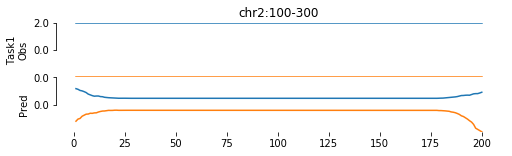

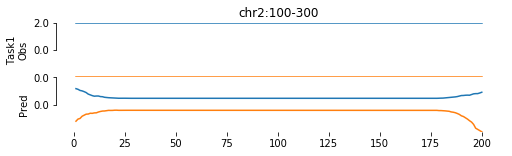

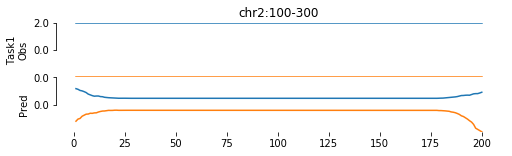

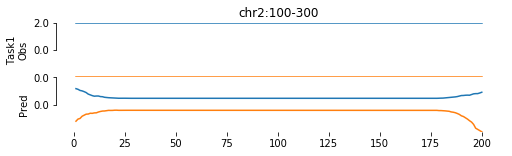

In [29]:
max_plot_width = 400
plot_seqlen = min(max_plot_width, input_seqlen)
trim_edge = max((input_seqlen - max_plot_width) // 2, 0)

xlim = [trim_edge, input_seqlen - trim_edge]
fig_width = 8 / 200 * plot_seqlen
rotate_y=90
fig_height_per_track=1
tasks = model.tasks

for idx in idx_set:
    # get the interval for that idx
    r = get_dataset_item(valid['metadata']['range'], idx)
    interval = pybedtools.create_interval_from_list([r['chr'], int(r['start']), int(r['end'])])
    interval_str = f"{interval.chrom}:{interval.start + trim_edge}-{interval.end - trim_edge}"

    # make prediction

    fe = FastaExtractor(ds.fasta_file)
    seq = fe([resize_interval(interval, input_seqlen, ignore_strand=True)])
    x = model.neutral_bias_inputs(input_seqlen, input_seqlen)
    x['seq'] = seq
    pred = model.predict(x)


    # compile the list of tracks to plot
    viz_dict =flatten_list([[
        # Observed
        (f"{task}\nObs", to_neg(y_true[f'{task}/profile'][idx])),
        # Predicted
        (f"\nPred", to_neg(pred[f'{task}/profile'][0] * np.exp(pred[f'{task}/counts'][0]))),
    ] for task_idx, task in enumerate(tasks)])

    sl = slice(*xlim)
    # Get ylim
    ylim = []
    for task in tasks:
        m = y_true[f'{task}/profile'][idx][sl].max()
        ylim.append((-m,m))
        m = (pred[f'{task}/profile'][0] * np.exp(pred[f'{task}/counts'][0])).max()
        ylim.append((-m,m))

    fig = plot_tracks(filter_tracks(viz_dict, xlim),
                      title=interval_str,
                      fig_height_per_track=fig_height_per_track,
                      rotate_y=rotate_y,
                      use_spine_subset=True,
                      # color=colors,
                      fig_width=fig_width,
                      ylim=ylim,
                      legend=False)
    fig.align_ylabels()
    sns.despine(top=True, right=True, bottom=True)